In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns',500)

In [2]:
df = pd.read_excel('churn.xlsx')

In [3]:
varc = [c for c in df.columns if c[:2]=='V_']
vard = [c for c in df.columns if c[:2]=='C_']

In [4]:
lst_iv = []
for i,v in enumerate(varc):
    if i >= 0:
        max_iv = 0
        bestk = 0
        for k in range(2,6):
            aux = df[[v,'TARGET']].copy()
            aux[v] = pd.cut(aux[v],bins=k,include_lowest=True).astype(str) 
            aux['n'] = 1
            aux = aux.pivot_table(index=v,
                                  columns='TARGET',
                                  values='n',
                                  aggfunc='count')
            aux.reset_index(inplace=True)
            for j in range(2):
                aux[j] = aux[j]/aux[j].sum()
            aux['woe'] = np.log(aux[0]/aux[1])
            aux['iv'] = aux['woe']*(aux[0]-aux[1])
            iv = aux['iv'].sum()
            if (iv>max_iv) & (~np.isinf(iv)):
                max_iv = iv
                bestk = k
        aux = df[[v,'TARGET']].copy()
        aux[v] = pd.cut(aux[v],bins=bestk,include_lowest=True).astype(str) 
        aux['n'] = 1
        aux = aux.pivot_table(index=v,
                              columns='TARGET',
                              values='n',
                              aggfunc='count')
        aux.reset_index(inplace=True)
        for j in range(2):
            aux[j] = aux[j]/aux[j].sum()
        aux['woe'] = np.log(aux[0]/aux[1])
        df[v] = pd.cut(df[v],bins=bestk,include_lowest=True).astype(str)
        df = df.merge(aux[[v,'woe']],on=v,how='inner')
        df.rename(columns={'woe':'W_%s'%v[2:]},inplace=True)
        lst_iv.append((v,max_iv,bestk))

In [5]:
df_iv = pd.DataFrame(lst_iv,columns=['caracteristica','iv','bins'])
df_iv.sort_values('iv',ascending=False,inplace=True)
df_iv

caracteristica        iv  bins
9     V_CS_CALLS  0.563956     5
2    V_T_DAY_CHG  0.552685     5
1    V_N_VM_MESS  0.108727     5
8    V_T_INT_CHG  0.074084     4
4    V_T_EVE_CHG  0.073018     3
7  V_T_INT_CALLS  0.066547     5
6    V_T_NIG_CHG  0.021401     4
5  V_T_NIG_CALLS  0.018573     3
3  V_T_EVE_CALLS  0.008637     4
0    V_ACCT_LGHT  0.006406     5

In [6]:
lst_iv = []
for i,v in enumerate(vard):
    aux = df[[v,'TARGET']].copy()
    aux['n'] = 1
    aux = aux.pivot_table(index=v,
                          columns='TARGET',
                          values='n',
                          aggfunc='count')
    aux.reset_index(inplace=True)
    for j in range(2):
        aux[j] = aux[j]/aux[j].sum()
    aux['woe'] = np.log(aux[0]/aux[1])
    aux['iv'] = aux['woe']*(aux[0]-aux[1])
    df = df.merge(aux[[v,'woe']],on=v,how='inner')
    df.rename(columns={'woe':'W_%s'%v[2:]},inplace=True)
    lst_iv.append((v,aux['iv'].sum(),np.nan))

In [7]:
lst_iv

[('C_IP', 0.35951779523791005, nan), ('C_VMP', 0.07523205435128297, nan)]

In [8]:
df_iv = df_iv.append(pd.DataFrame(lst_iv,columns=['caracteristica','iv','bins']))
df_iv.sort_values('iv',ascending=False,inplace=True)
df_iv

caracteristica        iv  bins
9     V_CS_CALLS  0.563956   5.0
2    V_T_DAY_CHG  0.552685   5.0
0           C_IP  0.359518   NaN
1    V_N_VM_MESS  0.108727   5.0
1          C_VMP  0.075232   NaN
8    V_T_INT_CHG  0.074084   4.0
4    V_T_EVE_CHG  0.073018   3.0
7  V_T_INT_CALLS  0.066547   5.0
6    V_T_NIG_CHG  0.021401   4.0
5  V_T_NIG_CALLS  0.018573   3.0
3  V_T_EVE_CALLS  0.008637   4.0
0    V_ACCT_LGHT  0.006406   5.0

In [9]:
best_features=['W_%s'%x[2:] for x in list(df_iv.loc[df_iv.iv>=0.05]['caracteristica'])]

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [11]:
X = df[best_features].copy()
y = df['TARGET'].copy()

In [12]:
Xt, Xv, yt, yv = train_test_split(X,y,train_size=0.7)

/home/jose/Documentos/rubik/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
modelo = LogisticRegression()

In [14]:
modelo.fit(Xt,yt)

/home/jose/Documentos/rubik/lib64/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
print(roc_auc_score(y_score=modelo.predict_proba(Xt)[:,1],y_true=yt))
print(roc_auc_score(y_score=modelo.predict_proba(Xv)[:,1],y_true=yv))

0.8719919904025969
0.8643527088732568


#### Scoring 

In [16]:
PDO = 20
score_base = 280
odds_base = 3
factor = PDO/np.log(2)
offset = score_base-factor*np.log(odds_base)

In [17]:
betas = list(modelo.coef_[0])
alpha = modelo.intercept_[0]

In [18]:
n = len(betas)

In [19]:
for i,v in enumerate(best_features):
    df['P_%s'%v[2:]] = ((-df[v]*betas[i]+alpha/n)*factor+offset/n).astype(int)

In [20]:
df['score'] = df[[v for v in df.columns if v[:2]=='P_']].sum(axis=1)

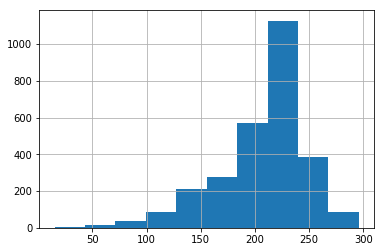

In [21]:
df.score.hist()

In [22]:
df.score.describe()

count    2801.000000
mean      207.533738
std        40.779508
min        15.000000
25%       191.000000
50%       217.000000
75%       234.000000
max       296.000000
Name: score, dtype: float64

In [23]:
df.score.max()-df.score.min()

281

In [24]:
for v in list(df_iv.loc[df_iv.iv>=0.05]['caracteristica']):
    aux = df[[v,'P_%s'%v[2:]]].copy()
    aux.drop_duplicates(inplace=True)
    print(aux)

        V_CS_CALLS  P_CS_CALLS
0    (-0.007, 1.2]          34
389     (2.4, 3.6]          40
462     (1.2, 2.4]          32
628     (4.8, 6.0]         -59
650     (3.6, 4.8]         -35
        V_T_DAY_CHG  P_T_DAY_CHG
0   (43.266, 51.88]          -37
1  (26.038, 34.652]           42
2  (17.424, 26.038]           31
4  (34.652, 43.266]           25
9   (8.766, 17.424]           30
    C_IP  P_IP
0     No    33
678  Yes   -26
       V_N_VM_MESS  P_N_VM_MESS
0     (17.2, 25.8]           60
1     (25.8, 34.4]           30
5     (34.4, 43.0]           40
10     (8.6, 17.2]           52
421  (-0.044, 8.6]           19
    C_VMP  P_VMP
0     Yes     30
757    No     22
        V_T_INT_CHG  P_T_INT_CHG
0      (2.7, 3.605]           28
176    (1.795, 2.7]           26
309   (3.605, 4.51]            2
355  (0.885, 1.795]           33
                    V_T_EVE_CHG  P_T_EVE_CHG
0              (13.533, 20.327]           26
10  (6.718999999999999, 13.533]           41
11              (20.327, 27.

In [25]:
df['r_score'] = pd.cut(df['score'],bins=range(0,330,30),include_lowest=True).astype(str)

In [29]:
df.pivot_table(index='r_score',
               columns='TARGET',
               aggfunc='count',
               values=varc[0],
               fill_value=0).to_clipboard()